In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy

In [2]:
import git
# find top-level of git repo and add it to the path
repo = git.Repo('.', search_parent_directories=True)

import sys
sys.path.insert(0, repo.working_tree_dir)

In [3]:
import utils.plotUtils as plu

In [4]:
def random_poisson(mu, sigma=None, size=1):
    if sigma is None:
        return np.random.poisson(mu, size)
    
    M = sigma **2 / mu
    K = (mu / sigma) ** 2
    return random_poisson(K, size=size) * M
    

In [5]:
def get_model(sig_x, bkg_x, data_x, bins=None, sig_w=None, bkg_w=None):
    h_sig, bins, _ = plt.hist(sig_x, bins=bins, weights=sig_w, histtype='step', linewidth=2)
    h_sig_err = np.sqrt(np.histogram(sig_x, bins=bins, weights=sig_w**2)[0])
    
    h_bkg, bins, _ = plt.hist(bkg_x, bins=bins, weights=bkg_w, alpha=0.5, label='bkg', color='blue')
    h_bkg_err = np.sqrt(np.histogram(bkg_x, bins=bins, weights=bkg_w**2)[0])

    plt.fill_between(
        bins, 
        np.append(h_bkg - h_bkg_err, 0), 
        np.append(h_bkg + h_bkg_err, 0), 
        step='post', 
        alpha=0.25, 
        color='grey', 
    )

    h_data = np.histogram(data_x, bins=bins)[0]
    h_data_err = np.sqrt(h_data)
    center = (bins[:-1] + bins[1:]) / 2
    plt.errorbar(center, h_data, yerr=np.sqrt(h_data), fmt='o', color='black', label='data')
    
    return (h_sig, h_sig_err), (h_bkg, h_bkg_err), (h_data, h_data_err)

In [6]:
def interp_at(value, x, y, npoints=3):
    nearest_points = np.sort(np.argsort(np.abs(x - value))[:npoints])
    return np.interp(value, x[nearest_points], y[nearest_points])
    
    

In [7]:
ms = [120]
R = np.random.uniform(0.8,1.2, size=1)
M = ms[np.random.randint(len(ms))]

In [8]:
gen_sig = lambda n, m=100 : np.random.normal(m, 0.05 * m, n)
gen_bkg = lambda n : np.random.lognormal( np.log(100),  0.5, n)

r_sig = 50
r_bkg = 5000

data_x = np.concatenate([gen_sig( int(R * r_sig), m=M ), gen_bkg( int(r_bkg) )])

In [9]:
from tqdm import tqdm

def minimize(L, atol=1e-6, rtol=1e-12, maxsteps=10000, lr=0.01, verbose=False):
    nparams = len(list(L.parameters()))
    
    if verbose:
        print(f'Optimizing {nparams} parameters')
    
    if nparams == 0: return
    
    optimizer = torch.optim.Adam(L.parameters(), lr=lr)
            
    loss = L()
    if loss.ndim == 1:
        loss = loss.mean()
        
    it = tqdm(range(maxsteps)) if verbose else range(maxsteps)
    for i in it:    
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()       
        
        previous_loss = loss.item()
        
        loss = L()
        if loss.ndim == 1:
            loss = loss.mean()
            
        adiff = abs(previous_loss - loss.item())
        rdiff = abs(previous_loss - loss.item()) / abs(previous_loss)
            
        if (adiff and adiff < atol) or (rdiff and rdiff < rtol):
            break                

        if verbose and i % 10 == 0:
            it.set_description(f'loss={loss.item():.3f} absdiff={adiff:.3e} reldiff={rdiff:.3e}')
    
    if verbose:
        print(f'loss={loss.item():.3f} absdiff={adiff:.3e} reldiff={rdiff:.3e}')

In [13]:
mc_sig = 1
mc_bkg = 1
    
sig_x = np.stack([ gen_sig( int(r_sig * mc_sig), m=m ) for m in ms ], axis=1)
sig_w = np.ones_like(sig_x) / mc_sig

bkg_x = gen_bkg( int(r_bkg * mc_bkg) )
bkg_w = np.ones_like(bkg_x) / mc_bkg

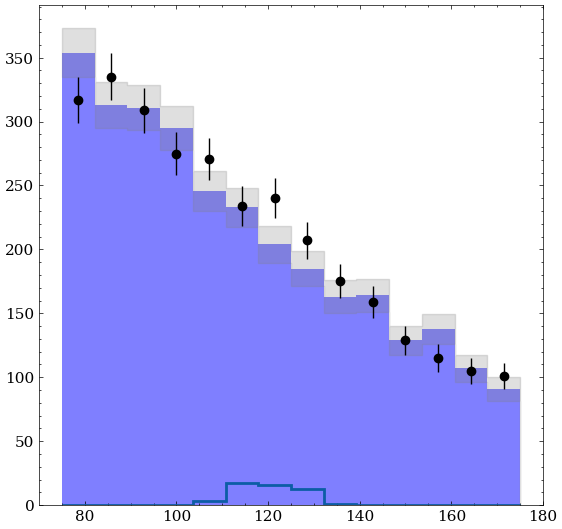

In [14]:
(s, serr), (b, berr), (d, derr) = get_model(sig_x, bkg_x, data_x, bins=np.linspace(75, 175, 15), sig_w=sig_w, bkg_w=bkg_w)
s, serr, b, berr, d, derr = [ torch.from_numpy(x) for x in [s, serr, b, berr, d, derr] ]

In [12]:

class Likelihood(torch.nn.Module):
    """
    P(nobs | nexp) = nexp^nobs / nobs! * exp(-nexp)

    log P(nobs | nexp) = nobs * log(nexp) - nexp - log(nobs!)
    """
    
    def __init__(self):
        super().__init__()
        
    def forward(self, nexp, nobs):
        log_nobs_factorial = torch.lgamma( nobs + 1 )
        log_poisson = nobs * torch.log(nexp) - nexp - log_nobs_factorial
        return - 2 * log_poisson

In [25]:
class SignalModel(Likelihood):
    def __init__(self, r, s, b, d):
        super().__init__()
        self.r = r
        self.s = s
        self.b = b
        self.d = d
    def forward(self, r=None):
        if r is None: r = self.r
        return super().forward(r * self.s + self.b, self.d)
    
class StatisticalModel(Likelihood):
    def __init__(self, k, n, N):
        super().__init__()
        self.k = k
        self.n = n
        self.N = N
    def forward(self, k=None):
        if k is None: k = self.k
        return super().forward(k * self.n, self.N)

In [26]:
class Summation(torch.nn.Module):
    def __init__(self, *models):
        super().__init__()
        self.models = torch.nn.ModuleList(models)
    def forward(self, *args, **kwargs):
        return sum( m(*args, **kwargs) for m in self.models )

In [ ]:
class Model(Likelihood):
    def __init__(self, r, s, b, )

In [27]:

k = berr**2 / b
B = b / k

r_mle = torch.nn.Parameter(torch.tensor(1.0), requires_grad=True)
k_mle = torch.nn.Parameter(k, requires_grad=False)

my_model = Summation(
    SignalModel(r_mle, s, k_mle * B, r_mle * s + b),
    StatisticalModel(k_mle, B, b)
)

minimize(my_model, verbose=True)

Optimizing 2 parameters


loss=14.223 absdiff=2.298e-05 reldiff=1.616e-06:   0%|          | 1/10000 [00:00<12:09, 13.71it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [23]:
r_mle, k_mle

(Parameter containing:
 tensor(nan, requires_grad=True),
 Parameter containing:
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000], dtype=torch.float64))

In [83]:
class StatsHEP:
    def __init__(self, s, b, d, b_err, verbose=False):

        self.s = s
        self.b = b
        self.d = d
        self.b_err = b_err

        k = b_err**2 / b
        B = b / k
        
        self.r_mle = torch.nn.Parameter( torch.ones(1), requires_grad=True )
        self.k_mle = torch.nn.Parameter( k, requires_grad=True )
        self.MLE = Summation(
            SignalModel(self.r_mle, s, self.k_mle * B, d),
            StatisticalModel(self.k_mle, B, b),
        )

        minimize(self.MLE, lr=1e-2, verbose=verbose) 

        self.r_scan = torch.linspace(0, 5, 1000)
        self.k_scan = torch.nn.Parameter(k.repeat(len(self.r_scan), 1), requires_grad=False)

        self.L = Summation(
            SignalModel(self.r_mle, s, self.k_scan * B, d),
            StatisticalModel(self.k_scan, B, b),
        )
        
    def __call__(self, r=None, b=None):
        if r is None:
            r = self.r_scan
            
        with torch.no_grad():
            nll = self.L(r) - self.MLE()
        
        return nll
    
    def tmu(self, r=None): return self(r)
    
    def tmu_pvalue(self, r=None):
        if r is None: r = self.r_scan
        tmu = self.tmu(r)
        return scipy.stats.chi2.sf(tmu, 1)
    
    def tilde_tmu(self, r=None):
        if r is None: r = self.r_scan
        
        with torch.no_grad():
            if self.r_mle.item() >= 0:
                nll = self.L() - self.MLE()
            else:
                nll = self.L()
                nll -= nll[0]
                
        return np.interp(r, self.r_scan.numpy(), nll.numpy())

    def q0(self):
        with torch.no_grad():
            if self.r_mle.item() >= 0:
                return (self.L(0) - self.MLE())
            else:
                return 0
            
    def q0_pvalue(self):
        q0 = self.q0()
        return scipy.stats.norm.sf(np.sqrt(q0))
    
    def qmu(self, r=None):
        if r is None: r = self.r_scan
        
        tmu = self.tmu(r)            
        mask = self.r_mle.item() <= r
        return np.where(mask, tmu, 0)
        
    def qmu_pvalue(self, r=None):
        if r is None: r = self.r_scan
        
        qmu = self.qmu(r)
        return scipy.stats.norm.sf(np.sqrt(qmu))
    
    def upperlimit(self):
        r = torch.linspace(0, 5, 1000)
        pmu = self.qmu_pvalue(r)
        pb = self.qmu_pvalue(0)
        pvalue = pmu / (1 - pb)

        return interp_at(0.05, pvalue, r)
    
    def upperlimit_quantile(self, quantile=[0.025,0.16,0.5,0.84,0.975]):
        r_up = self.upperlimit()
        qup = self.qmu(r_up)

        sigma = r_up / np.sqrt(qup)

        x = np.linspace(-4,4,100)
        y = scipy.stats.norm.cdf(x)
        return sigma * np.interp(quantile, y, x) + r_up
        

In [84]:
stats = StatsHEP(s, b, d, berr, verbose=True)

Optimizing 2 parameters


loss=11595.031 absdiff=1.675e+01 reldiff=1.443e-03:   0%|          | 1/10000 [00:00<01:58, 84.25it/s]


RuntimeError: Trying to backward through the graph a second time (or directly access saved tensors after they have already been freed). Saved intermediate values of the graph are freed when you call .backward() or autograd.grad(). Specify retain_graph=True if you need to backward through the graph a second time or if you need to access saved tensors after calling backward.

In [80]:
stats.MLE()

tensor([31.4287], dtype=torch.float64, grad_fn=<AddBackward0>)

In [82]:
stats.r_mle, stats.b_mle, stats.b

(Parameter containing:
 tensor([53.3963], requires_grad=True),
 Parameter containing:
 tensor([116.1361], dtype=torch.float64),
 tensor([116.1361], dtype=torch.float64))

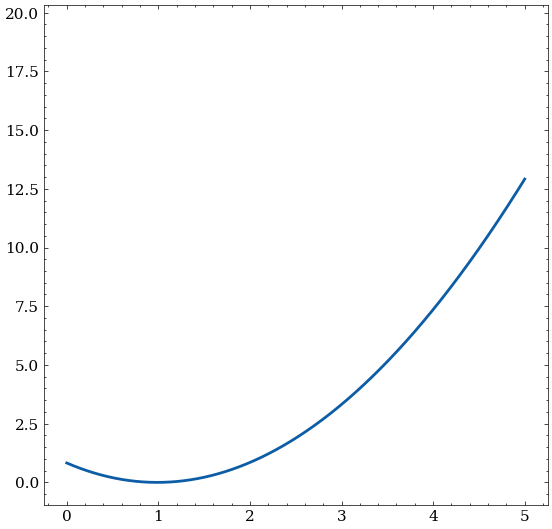

In [40]:
with torch.no_grad():
    r_scan = torch.linspace(0, 5, 1000)
    plu.graph_array(
        r_scan,
        stats(r_scan),
    )


In [41]:
datacard = """
imax * number of channels
jmax * number of backgrounds
kmax * number of nuisance parameters (sources of systematical uncertainties)
----
bin bin1
observation {nobs}
bin           bin1          bin1  
process       sig           bkg  
process       0             1    
rate          {nsig:0.2f}   {nbkg:0.2f}
----
""".format(
    nobs=torch.sum(d),
    nsig=torch.sum(s[0]),
    nbkg=torch.sum(b),
)

In [42]:
import utils.combineUtils as combine

In [43]:
!readlink -f ~/eightb/combine/../

/uscms_data/d3/ekoenig/8BAnalysis/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit


In [44]:
combine_path = '/uscms_data/d3/ekoenig/8BAnalysis/combine/CMSSW_10_2_13/src/HiggsAnalysis/CombinedLimit'
with combine.Process(combine_path, datacard, remove_workspace=True) as result:

    ...

In [45]:
stats.upperlimit()

3.158158302307129

In [46]:
print(result.log.decode())

perl: warning: Setting locale failed.
perl: warning: Please check that your locale settings:
	LANGUAGE = (unset),
	LC_ALL = (unset),
	LANG = "C.UTF-8"
    are supported and installed on your system.
perl: warning: Falling back to the standard locale ("C").
 <<< Combine >>> 
>>> random number generator seed is 123456
>>> method used is AsymptoticLimits

 -- AsymptoticLimits ( CLs ) --
Observed Limit: r < 2.9132
Expected  2.5%: r < 1.1581
Expected 16.0%: r < 1.5450
Expected 50.0%: r < 2.1484
Expected 84.0%: r < 2.9963
Expected 97.5%: r < 4.0048

Done in 0.00 min (cpu), 0.00 min (real)

